In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [50]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]  # basically passes the history through


graph_builder = StateGraph(State) 

## LLM Node

In [5]:
import os
from langchain_openai import AzureChatOpenAI

In [6]:
llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=10,
    max_retries=2,
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
graph_builder.add_node("chatbot", chatbot)

## Simple graph

In [9]:
graph_builder.add_edge(START, "chatbot")

In [10]:
graph_builder.add_edge("chatbot", END)

In [11]:
graph = graph_builder.compile()

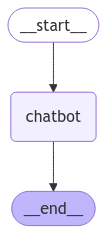

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

## Questions
* how do I change the system prompt

## Search tool

In [32]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper

In [34]:
"""
    region: See https://pypi.org/project/duckduckgo-search/#regions
    safesearch: strict, moderate, off
    time: d, w, m, y
    backend: auto, html, lite
    source: text, news, images
"""


ddg_api_wrapper = DuckDuckGoSearchAPIWrapper(
    region="wt-wt",
    safesearch="moderate",
    time='2024-01-01..2025-01-01',
    max_results = 5,
    backend = "auto",
    source = "news",
)

tool_description = """'A wrapper around Duck Duck Go Search. Useful for when you need to answer questions about current events. Input should be a search query."""

search_tool = DuckDuckGoSearchResults(
    api_wrapper = ddg_api_wrapper,
    description = tool_description,
    max_results = '5', # overrides the api wrapper arguments FYI
    backend = 'news', # overrides the api wrapper arguments FYI
    output_format="list",
)

In [35]:
search_tool.invoke("Obama")

[{'snippet': 'Ben Stiller asked Barack Obama to make a cameo in season 2 of "Severance," and he got a quick reply from the former president',
  'title': "Ben Stiller offered Barack Obama a cameo in 'Severance'",
  'link': 'https://www.nj.com/tv/2025/03/ben-stiller-offered-barack-obama-a-cameo-in-severance.html',
  'date': '2025-03-05T22:05:00+00:00',
  'source': 'NJ.com'},
 {'snippet': '(CNN) - The second season of Apple TV\'s popular show "Severance" came close to having a presidential cameo. Ben Stiller, who is an executive producer and director on the show, revealed to Jimmy Kimmel that he asked former President Barack Obama to appear on the show. Stiller said the role would have been the voice of the Lumon building.',
  'title': "Former President Barack Obama turned down role in 'Severance'",
  'link': 'https://www.wabi.tv/2025/03/06/former-president-barack-obama-turned-down-role-severance/',
  'date': '2025-03-06T05:03:00+00:00',
  'source': 'WABI-TV'},
 {'snippet': 'The clash bet

## Agent with tool

In [51]:
import json
from langchain_core.messages import ToolMessage

In [52]:
llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=10,
    max_retries=2,
)

tools = [search_tool] # bind all tools that LLM can access here
llm_with_tools = llm.bind_tools(tools) # bind so that LLM knows how to generate the tool call

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [53]:
# Allows for multiple tools so that one/more toolls can be selected and ran

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [54]:
search_tool_node = BasicToolNode(tools=[search_tool])

In [55]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("search_tool", search_tool_node)

In [56]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools" # doenst have to same name given to your tools cos you can map it in the edges
    return END

In [57]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "search_tool", END: END},
) # allows the LLM to either use the tool or exit

graph_builder.add_edge("search_tool", "chatbot") # allows the tool to feedback to the LLM
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

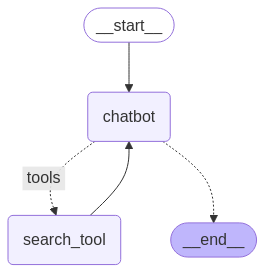

In [58]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [59]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"snippet": "Cleveland defeated Boston last weekend to regain the top spot in these power rankings. With around 20 games remaining, teams are preparing for a playoff push or stepping up their tanking efforts. 1. Cleveland Cavaliers (51-10,", "title": "NBA power rankings 2024-25: Cavaliers retake top spot in rankings, Pistons move into top 10", "link": "https://www.msn.com/en-us/sports/nba/nba-power-rankings-2024-25-cavaliers-retake-top-spot-in-rankings-pistons-move-into-top-10/ar-AA1waORq", "date": "2025-03-05T22:54:00+00:00", "source": "NBC Sports"}, {"snippet": "The NBA announced today its monthly player awards for February. This includes the NBA Defensive Player of the Month, Player of the Month and Rookie of the Month after the league named its coaches of the month on Monday.", "title": "NBA Announces 2024-25 February Rookie of the Month Award", "link": "https://www.msn.com/en-us/sports/other/nba-announces-2024-25-february-rookie-of-the-month-award/ar-AA1Agt